## rgb to hsv

In [1]:
!wget https://www.shutterstock.com/image-photo/colorful-silk-textured-fabric-surface-600nw-2358601495.jpg

--2024-10-27 10:43:35--  https://www.shutterstock.com/image-photo/colorful-silk-textured-fabric-surface-600nw-2358601495.jpg
Resolving www.shutterstock.com (www.shutterstock.com)... 3.163.125.27, 3.163.125.126, 3.163.125.2, ...
Connecting to www.shutterstock.com (www.shutterstock.com)|3.163.125.27|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 59860 (58K) [image/jpeg]
Saving to: ‘colorful-silk-textured-fabric-surface-600nw-2358601495.jpg.2’

colorful-silk-textu 100%[===================>]  58.46K  --.-KB/s    in 0.008s  

2024-10-27 10:43:35 (6.95 MB/s) - ‘colorful-silk-textured-fabric-surface-600nw-2358601495.jpg.2’ saved [59860/59860]



In [8]:
import numpy as np
from numba import cuda
from PIL import Image

@cuda.jit
def rgb_to_hsv_cuda(rgb_array, hsv_array):
    # Get the 2D position of the thread in the array
    height, width = rgb_array.shape[0], rgb_array.shape[1]
    x, y = cuda.grid(2)  # 2D grid

    # Check bounds
    if x < height and y < width:
        r = rgb_array[x, y, 0] / 255.0
        g = rgb_array[x, y, 1] / 255.0
        b = rgb_array[x, y, 2] / 255.0

        c_max = max(r, g, b)
        c_min = min(r, g, b)
        delta = c_max - c_min

        # Calculate Hue
        if delta == 0:
            h = 0.0
        elif c_max == r:
            h = (60 * ((g - b) / delta) + 360) % 360
        elif c_max == g:
            h = (60 * ((b - r) / delta) + 120) % 360
        else:  # c_max == b
            h = (60 * ((r - g) / delta) + 240) % 360

        # Calculate Saturation
        s = 0.0 if c_max == 0 else (delta / c_max)

        # Value
        v = c_max

        hsv_array[x, y, 0] = h
        hsv_array[x, y, 1] = s
        hsv_array[x, y, 2] = v

img = Image.open('/content/colorful-silk-textured-fabric-surface-600nw-2358601495.jpg')
rgb_data = np.array(img)

# Shape of the input
height, width, _ = rgb_data.shape

# Allocate output array
hsv_data = np.zeros((height, width, 3), dtype=np.float32)

# Define the size of the GPU grid
threads_per_block_x = 16
threads_per_block_y = 16
blocks_per_grid_x = (height + (threads_per_block_x - 1)) // threads_per_block_x
blocks_per_grid_y = (width + (threads_per_block_y - 1)) // threads_per_block_y

# Copy data to the device
rgb_device = cuda.to_device(rgb_data)
hsv_device = cuda.to_device(hsv_data)

# Launch the CUDA kernel
rgb_to_hsv_cuda[(blocks_per_grid_x, blocks_per_grid_y), (threads_per_block_x, threads_per_block_y)](rgb_device, hsv_device)

# Copy the result back to the host
hsv_data = hsv_device.copy_to_host()

print(hsv_data[0])



[[348.28125      0.969697     0.5176471 ]
 [349.30234      1.           0.5058824 ]
 [349.13043      1.           0.5411765 ]
 ...
 [193.71428      1.           0.4117647 ]
 [193.51352      1.           0.43529412]
 [194.21053      0.974359     0.45882353]]


# hsv to rgb

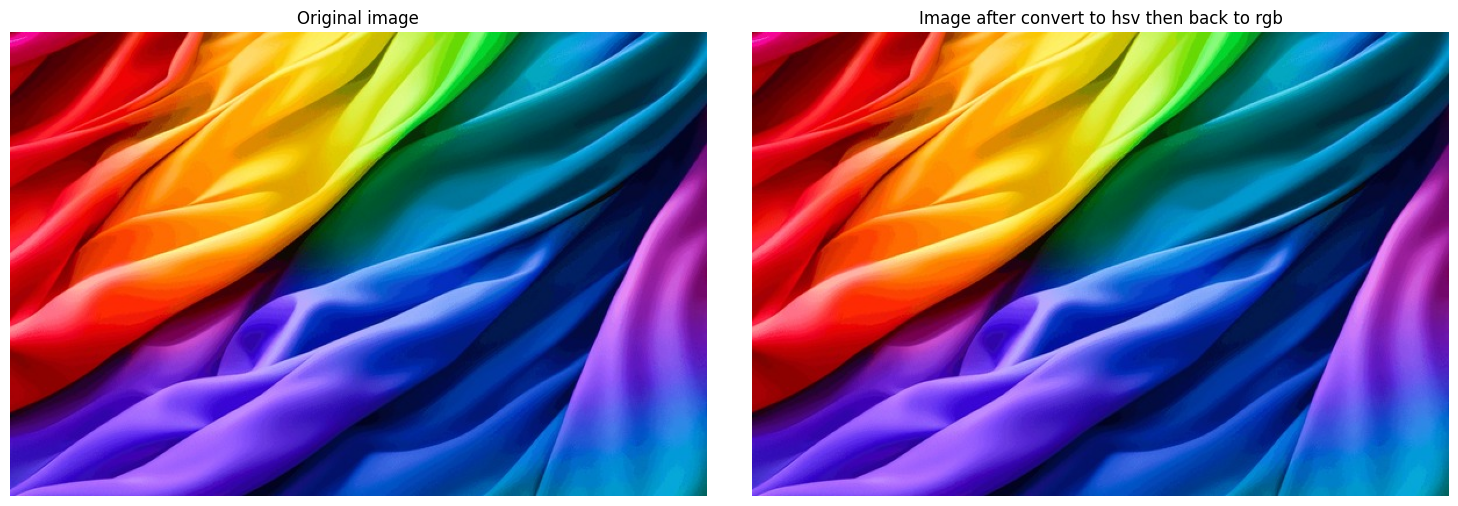

In [10]:
import matplotlib.pyplot as plt

@cuda.jit
def hsv_to_rgb_cuda(rgb_array, hsv_array):
    # Get the 2D position of the thread in the array
    height, width = hsv_array.shape[0], hsv_array.shape[1]
    x, y = cuda.grid(2)  # 2D grid

    # Check bounds
    if x < height and y < width:
        h = rgb_array[x, y, 0]
        s = rgb_array[x, y, 1]
        v = rgb_array[x, y, 2]

        d = h/60
        hi = int(d) % 6
        f = d - hi
        l = v * (1 - s)
        m = v * (1 - f * s)
        n = v * (1 - (1 - f) * s)


        if hi == 0:
            r, g, b = v, n, l
        elif hi == 1:
            r, g, b = m, v, l
        elif hi == 2:
            r, g, b = l, v, n
        elif hi == 3:
            r, g, b = l, m, v
        elif hi == 4:
            r, g, b = n, l, v
        elif hi == 5:
            r, g, b = v, l, m

        rgb_array[x, y, 0] = r
        rgb_array[x, y, 1] = g
        rgb_array[x, y, 2] = b

rgb_data1 = np.zeros((height, width, 3), dtype=np.uint8)

# Copy data to the device
rgb_device = cuda.to_device(rgb_data1)
hsv_device = cuda.to_device(hsv_data)

# Launch the CUDA kernel
hsv_to_rgb_cuda[(blocks_per_grid_x, blocks_per_grid_y), (threads_per_block_x, threads_per_block_y)](rgb_device, hsv_device)

# Copy the result back to the host
rgb_data1 = hsv_device.copy_to_host()
uint8_array = (rgb_data).astype(np.uint8)

# output_img = Image.fromarray(uint8_array)

# # Display the grayscale image using IPython
# display(output_img)

# Create a figure and a grid of subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Display each image
axes[0].imshow(rgb_data)
axes[0].axis('off')  # Hide axes for a cleaner look
axes[0].set_title('Original image')

axes[1].imshow(uint8_array)
axes[1].axis('off')
axes[1].set_title('Image after convert to hsv then back to rgb')


# Show the images
plt.tight_layout()
plt.show()